### Restaurant and Bar Employment Growth as Share of Total

In [1]:
import requests
import json
import pandas as pd
import config

%matplotlib inline

Jolts series: 
    
JTS72000000HIL
JTS72000000HIR
JTS72000000JOL
JTS72000000JOR
JTS72000000LDL
JTS72000000LDR
JTS72000000OSL
JTS72000000OSR
JTS72000000QUL
JTS72000000QUR
JTS00000000QUR
JTS72000000TSL
JTS72000000TSR

AHE: 

CES7072000008
CES0000000008

IPUTN722___L000



In [19]:
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(config.bls_key)
headers = {'Content-type': 'application/json'}
series_dict = {
    'Total': 'CES0000000001',
    'Food Services and Drinking Places': 'CES7072200001',
    'Accomodation and Food Services': 'CES7072000001',
    'FSD_AHE': 'CES7072200008',
    'AFS_AHE': 'CES7072000008',
    'AFS_ALL': 'CES0500000008',
    'AFS_QU': 'JTS72000000QUR',
    'TOT_QU': 'JTS00000000QUR'
}
inv_map = {v: k for k, v in series_dict.iteritems()}
series_list = series_dict.values()  # Take just the series codes as a list

date_list = [("1990", "1998"), ("1999", "2008"), ("2009", "2017")]
df = pd.DataFrame()

In [20]:
for start, end in date_list:
    data = json.dumps({"seriesid":series_list, "startyear":start, "endyear":end})
    json_data = requests.post('{}{}'.format(url, key), headers=headers, data=data).json()
    # Store the relevant information in a dictionay and combine into a pandas dataframe
    d = {}
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        d[seriesId] = pd.DataFrame(series['data'])
        if len(series['data']) > 0:
            # Convert BLS API dates to readable format (YYYY-MM-DD)
            d[seriesId]['date'] = pd.to_datetime(d[seriesId]['period'] + ' ' + d[seriesId]['year'])
            # Keep only date and series values
            d[seriesId] = d[seriesId].sort_values(by='date')[['date', 'value']].set_index('date')
            # Rename and round
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId]).astype(float)
        else:
            d[seriesId]['date'] = pd.Series()
            d[seriesId]['value'] = pd.Series()
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId])
    df = df.append(pd.concat([d[series_list[x]] for x in range(len(d))], axis=1))

In [5]:
df.to_csv('Restaurant_Jobs.csv')

In [49]:
# Restaurant Share of Total
df['Rest_Share'] = df['Food Services and Drinking Places'] / df['Total']

# Take Annual Average
df2 = df.groupby(pd.PeriodIndex(df.index, freq='A'), axis=0).mean().diff().dropna()

# For Bar Chart
df2['All Other'] = df2['Total'] - df2['Food Services and Drinking Places']

# Restaurant Share of Change
df['Rest_Share_Ch'] = df['Food Services and Drinking Places'].diff() / df['Total'].diff()

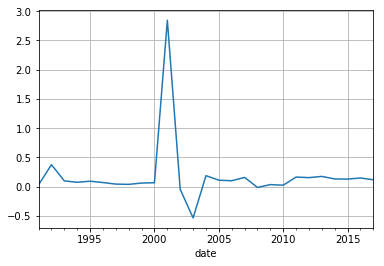

In [47]:
df2['Rest_Share'].plot(grid=True)

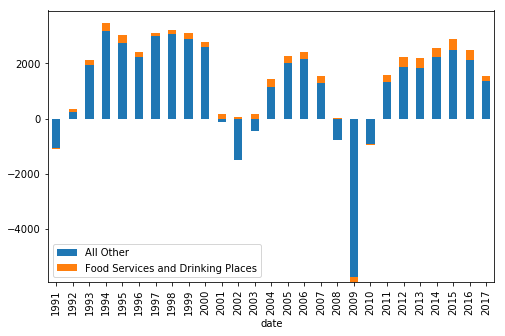

In [37]:
df2[['All Other', 'Food Services and Drinking Places']].plot(kind='bar', stacked=True, figsize=(8,5))